## Notebook contents: logistic regression, RFLR, HMM, FQ-learning models fit to 2ABT data
This notebook provides an overview of fitting and predicting mouse behavior in a two-armed bandit using descriptive, algorithmic, and theoretical models.


In [11]:
!pip install git+https://github.com/lindermanlab/ssm.git
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/2ABT_behavior_models-main/')
import os
os.listdir('/content/drive/MyDrive/Colab Notebooks/2ABT_behavior_models-main/')
import numpy as np
import pandas as pd
import seaborn as sns


import plot_models_v_mouse as bp
import model_policies as models
from sklearn.model_selection import train_test_split
import conditional_probs as cprobs
import resample_and_model_reps as reps
import model_fitting as fit

  Cloning https://github.com/lindermanlab/ssm.git to /tmp/pip-req-build-udpzy4jv
  Running command git clone --filter=blob:none --quiet https://github.com/lindermanlab/ssm.git /tmp/pip-req-build-udpzy4jv
  Resolved https://github.com/lindermanlab/ssm.git to commit 6c856ad3967941d176eb348bcd490cfaaa08ba60
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load in data and train-test-split

In [13]:
base_path = '/content/drive/MyDrive/Colab Notebooks/2ABT_behavior_models-main/'

data = pd.read_csv(os.path.join(base_path, 'bandit_data.csv'))
data.head()


,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse
0,11.0,11.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
1,12.0,12.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
2,13.0,13.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
3,14.0,14.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
4,15.0,15.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1


In [14]:
probs='80-20' # P(high)-P(low)
seq_nback=3 # history length for conditional probabilites
train_prop=0.7 # for splitting sessions into train and test
seed = np.random.randint(1000) # set seed for reproducibility

data = data.loc[data.Condition==probs] # segment out task condition

In [15]:
data = cprobs.add_history_cols(data, seq_nback) # set history labels up front

train_session_ids, test_session_ids = train_test_split(data.Session.unique(),
                                                       train_size=train_prop, random_state=seed) # split full df for train/test

data['block_pos_rev'] = data['blockTrial'] - data['blockLength'] # reverse block position from transition
data['model']='mouse'
data['highPort'] = data['Decision']==data['Target'] # boolean, chose higher probability port

train_features, _, _ = reps.pull_sample_dataset(train_session_ids, data)
test_features, _, block_pos_core = reps.pull_sample_dataset(test_session_ids, data)

bpos_mouse = bp.get_block_position_summaries(block_pos_core)
bpos_mouse['condition'] = 'mouse'

/content/drive/MyDrive/Colab Notebooks/2ABT_behavior_models-main/conditional_probs.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['000', '000', '001', '011', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '110', '101', '010', '100', '000', '001', '011', '111', '110', '100', '000', '000', '001', '010', '100', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '001', '010', '100', '000', '000', '000', '000', '000', '000', '00

# Plot conditional switch probabilities for just the mouse behavior first
Sort held out conditioned history sequences by full dataset P(switch|sequence)

In [16]:
# full dataset for sorting
df_mouse_symm_reference = cprobs.calc_conditional_probs(data, symm=True,
                                                        action=['Switch']).sort_values('pswitch')

/content/drive/MyDrive/Colab Notebooks/2ABT_behavior_models-main/conditional_probs.py:102: FutureWarning: The provided callable <function mean at 0x7899117cdee0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conditional_probs = df.groupby(group).agg(


/content/drive/MyDrive/Colab Notebooks/2ABT_behavior_models-main/conditional_probs.py:102: FutureWarning: The provided callable <function mean at 0x7899117cdee0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conditional_probs = df.groupby(group).agg(
/content/drive/MyDrive/Colab Notebooks/2ABT_behavior_models-main/conditional_probs.py:102: FutureWarning: The provided callable <function mean at 0x7899117cdee0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conditional_probs = df.groupby(group).agg(


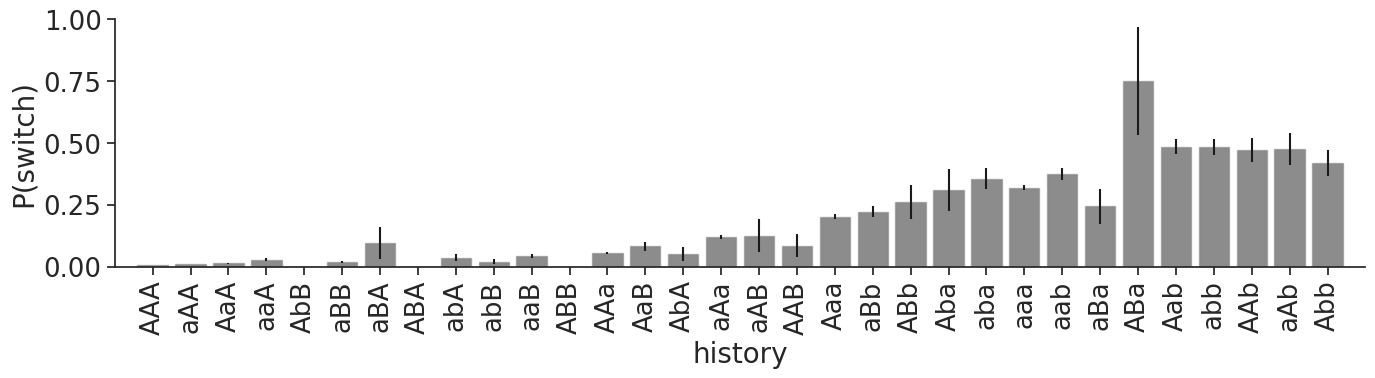

In [17]:
df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=True, action=['Switch', 'Decision'])
df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
bp.plot_sequences(df_mouse_symm, alpha=0.5)

# Fit models on training data, predict choice probabilities for held-out data
Model predictions (`model_probs`) for each held out session stored for plotting below.

## Logistic regression
Fit logistic regression on training set, with coefficients for choice history (up to trial n-L1), choice-reward interaction (up to trial n-L2), and reward history (up to trial n-L3).

In [18]:
L1 = 1 # choice history
L2 =  5 # choice * reward history
L3 = 0
memories = [L1, L3, L2, 1]

lr = models.fit_logreg_policy(train_features, memories) # refit model with reduced histories, training set
model_probs = models.compute_logreg_probs(test_features, lr_args=[lr, memories])

## Recursively formulated logistic regression (RFLR)

In [19]:
params, nll = fit.fit_with_sgd(fit.log_probability_rflr, train_features) # quick fit on RFLR parameters
alpha, beta, tau = params
print(f'alpha = {alpha[0]:.2f}')
print(f'beta = {beta[0]:.2f}')
print(f'tau = {tau[0]:.2f}')

model_probs = models.RFLR(test_features, params)

iteration  0 neg ll:  0.22442819
iteration  2500 neg ll:  0.18542515
iteration  5000 neg ll:  0.18537894
iteration  7500 neg ll:  0.18537714
alpha = 0.79
beta = 2.12
tau = 1.33


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

## Hidden Markov model (HMM)

In [21]:
q = 0.98 # 1-p(block transition)
p = 0.8 # p(reward | high port)

model_probs = models.compute_hmm_probs(test_features, parameters={'q':q, 'p':p})

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7898ba63dda0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


RuntimeError: no compiled object yet for <Library 'hmm_filter' at 0x78987da81090>

## forgetting Q-learning model (F-Q model)
Using $\alpha$, $\beta$, and $\tau$ parameters derived from fit RFLR above.

In [ ]:
T = (1-np.exp(-1/tau))/beta
k = 1-np.exp(-1/tau)
a = alpha

model_probs = models.fq_learning_model(test_features, parameters=[a, k, T])

# Predict action and plot
Apply policy ('greedy', 'stochastic', or 'softmax') to select actions from `model_probs` and plot behavior. Can add replicate runs for stochastic policies.

In [2]:
# Imports for better styling
import seaborn as sns
import matplotlib.pyplot as plt

# Set a cleaner seaborn theme
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.5)
plt.rcParams.update({
    'figure.figsize': (8, 6),
    'axes.labelweight': 'bold',
    'axes.titlesize': 20,
    'axes.titleweight': 'bold',
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'font.weight': 'bold'
})

# Better color palette
color_dict = {
    'mouse': sns.color_palette("Set2")[1],  # light green
    'model': sns.color_palette("Set2")[0],  # light blue
}

# --- Your analysis code (no logic changes) ---

# Apply the model to test data
model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

# Reconstruct block positions
block_pos_model = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
bpos_model = bp.get_block_position_summaries(block_pos_model)
bpos_model['condition'] = 'model'  # Label model predictions

# Aggregate model and mouse data
bpos_model_v_mouse = pd.concat((bpos_mouse, bpos_model))

# --- Separate Figures for Each Plot ---

# 1. Plot block position summaries
plt.figure()
bp.plot_by_block_position(
    bpos_model_v_mouse,
    subset='condition',
    color_dict=color_dict
)
plt.title('Block Position Summary: Mouse vs Model', fontweight='bold')
plt.xlabel('Block Position', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Plot sequences: mouse data with model overlay
symm_cprobs_model = cprobs.calc_conditional_probs(block_pos_model, symm=True, action=['Switch'])
symm_cprobs_model = cprobs.sort_cprobs(symm_cprobs_model, df_mouse_symm.history.values)

plt.figure()
bp.plot_sequences(
    df_mouse_symm,
    overlay=symm_cprobs_model,
    main_label='mouse',
    overlay_label='model'
)
plt.title('Conditional Sequences: Mouse vs Model', fontweight='bold')
plt.xlabel('Sequence', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Scatter plot comparison
plt.figure()
bp.plot_scatter(df_mouse_symm, symm_cprobs_model)
plt.title('Scatter Plot: Mouse vs Model', fontweight='bold')
plt.xlabel('Mouse Probability', fontweight='bold')
plt.ylabel('Model Probability', fontweight='bold')
plt.tight_layout()
plt.show()


NameError: name 'models' is not defined